In [1]:
import numpy as np
from numpy.linalg import eig
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize

Based on the following Qiskit tutorial: https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

# Let's define the operator:

In [2]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [3]:
H = hamiltonian.to_matrix()
print(H)

[[-0.4093+0.j     0.    +0.j     0.    -0.398j  0.181 +0.j   ]
 [ 0.    +0.j    -0.3867+0.j     0.181 +0.j     0.    +0.398j]
 [ 0.    +0.398j  0.181 +0.j     0.4093+0.j     0.    +0.j   ]
 [ 0.181 +0.j     0.    -0.398j  0.    +0.j     0.3867+0.j   ]]


In [4]:
hamiltonian_operator = Operator(hamiltonian)
hamiltonian_operator.draw(output='latex')

<IPython.core.display.Latex object>

# Let's find eigenvalues using classical numpy linear algebra package:

In [5]:
e,v=eig(H)
print("Eigenvalues:", e)
print("Eigenvectors:\n", v)

Eigenvalues: [-0.70293039+6.24707871e-18j -0.45308083-7.57079461e-17j
  0.70293039-6.06797210e-18j  0.45308083+3.47628378e-17j]
Eigenvectors:
 [[ 6.49638715e-01+0.00000000e+00j -1.13885050e-18+6.65864932e-01j
   7.01111754e-18-3.30320834e-01j -1.59629506e-01-4.32331142e-17j]
 [-2.91446790e-16+6.01307531e-01j  7.03606721e-01+0.00000000e+00j
   3.27546851e-01-2.90500924e-17j -2.28717515e-17+1.89947086e-01j]
 [-3.02255009e-17-3.30320834e-01j  1.59629506e-01+8.31587415e-17j
   6.49638715e-01+0.00000000e+00j  1.18760305e-16-6.65864932e-01j]
 [-3.27546851e-01-1.37383111e-16j -1.35473761e-17+1.89947086e-01j
  -1.69472202e-17-6.01307531e-01j  7.03606721e-01+0.00000000e+00j]]


# ...or even find smallest eigenvalue with Qiskit wrapper over classical numpy eigensolver:

In [6]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
minimal_eigenvalue = result.eigenvalue.real
print(minimal_eigenvalue)

-0.7029303944595301


# Now, let's use VQE algorithm

In [7]:
ansatz = EfficientSU2(hamiltonian.num_qubits)

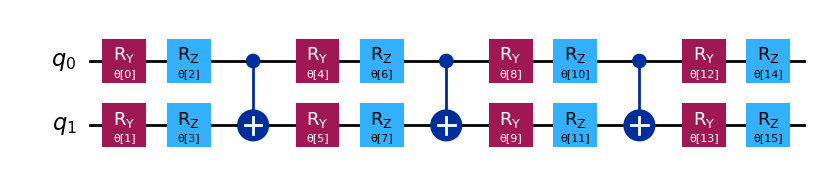

In [19]:
ansatz.decompose().draw("mpl")

In [9]:
num_params = ansatz.num_parameters
print(num_params)

16


In [10]:
print(hamiltonian.num_qubits)

2


In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    costs.append(energy)
    print(f"Iteration: {len(costs)+1}, cost: {energy}")

    return energy

In [12]:
costs = []

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

fake_manila = FakeManilaV2()

In [14]:
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

x0 = 2 * np.pi * np.random.random(num_params)
print(x0)

[5.90685019 1.47959955 3.24316651 0.91064745 4.41024457 2.5631947
 4.86250318 1.82609599 4.10095103 6.02092011 0.83682058 1.5221415
 3.17266634 2.09706798 1.06580929 1.24931111]


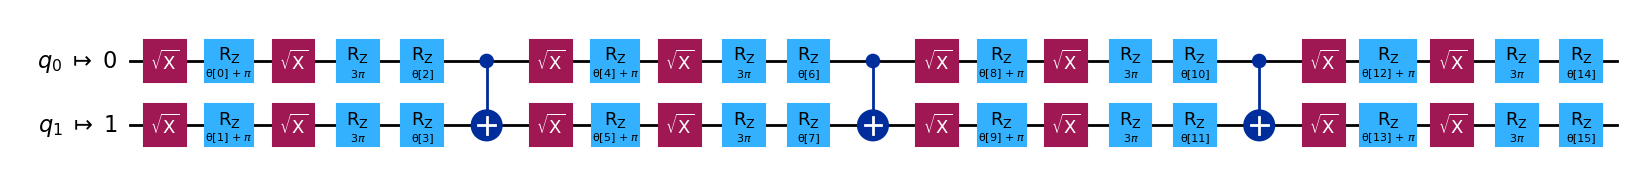

In [18]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [16]:
with Session(backend=fake_manila) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iteration: 2, cost: 0.36955168
Iteration: 3, cost: -0.13289982
Iteration: 4, cost: -0.23628000000000005
Iteration: 5, cost: -0.01931224000000001
Iteration: 6, cost: -0.24224292000000003
Iteration: 7, cost: -0.14487834
Iteration: 8, cost: -0.03538870000000004
Iteration: 9, cost: -0.27028568000000003
Iteration: 10, cost: -0.2397584
Iteration: 11, cost: -0.09211384000000002
Iteration: 12, cost: -0.30148312000000005
Iteration: 13, cost: -0.40868664000000005
Iteration: 14, cost: -0.10831312000000001
Iteration: 15, cost: -0.30676196
Iteration: 16, cost: -0.2393959
Iteration: 17, cost: -0.30135308000000005
Iteration: 18, cost: -0.42948522000000006
Iteration: 19, cost: -0.24262789999999998
Iteration: 20, cost: -0.31494874000000006
Iteration: 21, cost: -0.43122636000000003
Iteration: 22, cost: -0.43661408000000007
Iteration: 23, cost: -0.49857540000000006
Iteration: 24, cost: -0.40607798000000006
Iteration: 25, cost: -0.56605338
Iteration: 26, cost: -0.52785534
Iteration: 27, cost: -0.50577266


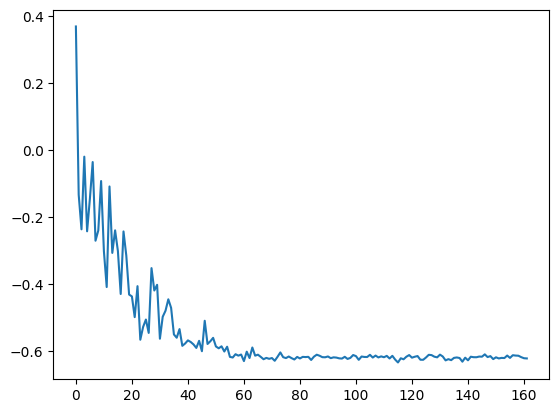

In [20]:
import matplotlib.pyplot as plt

plt.plot(costs)

# Exercise 1
Use different type of ansatz and check how this affects the result. \
Use this ansatz: ```TwoLocal(num_qubits, "ry", "cz")```


# Exercise 2
We got -0.6 instead of -0.7 :( \
This is because we used simulator of a real quantum computer.
Rework the above VQE example to return correct value of smallest eigenvalue by using ideal simulator: ```StatevectorEstimator```

# Exercise 3:
Using VQE algorithm calculate ground state energy of hydrogen molecule described by the below Hamiltonian.\
Check in the internet if the result is correct and deduce in what units it is expressed.

In [153]:
H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

# Homework
Run the above VQE algorithm on real quantum backend.